<a href="https://colab.research.google.com/github/Ali-Aslanli/testrepo/blob/main/TP_Intro_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bonjour !

Dans ce notebook, nous allons découvrir comment créer et utiliser un réseau de neurones pour classifier deux espèces de poissons présentes en Méditerranée : le **rouget** et la **brème de mer**.



Pour ce faire nous allons nous baser sur des images issues d'un supermarché en Turquie.
Ces données sont issues d'une étude collaborative industrie-université, disponible ici : https://ieeexplore.ieee.org/document/9259867

Ce sont des données labellisées, i.e chaque image est annotée, selon que c'est un rouget ou une brème.

Le texte en vert (précédé d'un #) correspond aux commentaires,
il est uniquement là pour aider à la compréhension du code.


Dans un premier temps, on importe les librairies Python nécessaires : on retrouve les bibliothèques classiques **numpy** et **pandas** pour le traitement de données, **matplotlib** pour l'affichage graphique, ainsi que **torch** et **torchvision** pour le deep learning.

In [ ]:
import os
from google.colab import files
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import zipfile
import PIL
from PIL import Image

import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from pathlib import Path

# Acquisition des données

On importe un dossier depuis le Gitlab de l'ISDM où se trouve notamment le dataset (jeu de données) qui contient les images de poissons :

In [ ]:
!git clone https://forgemia.inra.fr/isdm-formation/Formation-Introduction-Deep-Learning.git

In [ ]:
sys.path.append('/content/Formation-Introduction-Deep-Learning/Fish Dataset')
from mcq import mcq                                                             # importation pour avoir des qcm

In [ ]:
# Seed aléatoire qu'on fixe pour revenir sur les même résultats

import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

RANDOM_SEED = 64

set_all_seeds(RANDOM_SEED)

# Classification de poissons

## **Préparation du dataset**

On définit ici les espèces à classifier : le **rouget** et la **brème de mer** comme dit précédemment.

In [ ]:
data_dir = """/content/Formation-Introduction-Deep-Learning/Fish Dataset"""     # Chemin de notre dataset, importé depuis le GitHub
classes = ["Red Mullet","Red Sea Bream"]                                        # Nos deux poissons à classifier : rouget et brème de mer

On se procure le nombre d'exemple d'une classe (c'est le même pour les deux classes).

In [ ]:
_, _, files = next(os.walk(f"{data_dir}/{classes[0]}"))              # On récupère les fichiers de la classe "0", donc notre rouget, dans une variable "files"
file_count = len(files)                                                         # on récupère la taille de notre objet "files"

**QCM**

In [ ]:
mcq(1)

In [ ]:
# Utilisez cette cellule pour trouver la réponse


On initialise notre DataFrame Pandas à partir de nos images, i.e un format **pratique** et **compatible** pour stocker et utiliser nos données.

In [ ]:
image_paths = []
image_classes = np.array([[cls]*file_count for cls in classes]).reshape(-1)     # On crée un tableau de dimension (2000,), avec 1000 entités pour chacune des deux classes

for cls in classes:
    image_paths.extend(os.path.join(data_dir, cls, i) for i in os.listdir(os.path.join(data_dir, cls)))

data = pd.DataFrame({'path':image_paths, 'class':image_classes, })              # On crée le DataFrame Pandas
print(data)

Ce DataFrame comporte deux colonnes, le chemin d'une l'image et sa classe associée (label).

On définit une fonction de transformation à appliquer à nos images, pour qu'elles puissent être intégrées par le réseau de neurones. Cet fonction comprend notamment la conversion de l'image en tenseur.

In [ ]:
# Transformations qu'on souhaite appliquer au DataSet

transform = T.Compose([
        #T.Resize((224,224)),                                                   # Nos images sont déjà de taille 224 x 224, donc pas besoin de cette ligne
        T.ToTensor()])                                                          # Conversion en tenseur

Un tenseur est un objet mathématique permettant de généraliser les objets comme les scalaires, vecteurs, matrices, ... pour de plus grandes dimensions. Pour faire simple, un tenseur est un tableau multi-dimensionnelle.

Cette multi-dimensionalité permet de traiter des données comme nos images qui ont 3 dimensions (hauteur,largeur, et nombres de canaux de couleurs), mais aussi d'autres types : des vidéos (on rajoute la dimension du temps), du texte, de l'audio ...

On crée une instance de DataSet Pytorch, à partir d'une classe Dataset définie par nos soins.

In [ ]:
# On crée le DataSet Torch à partir de notre Dataset Pandas

str_to_int = {                                                                  # Dictionnaire python contenant nos classes et l'indice associé
 'Red Mullet': 0,
 'Red Sea Bream': 1}

class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=T.ToTensor()):                 # Le constructeur de classe prends trois paramètres
        self.data = data                                                        # dataFrame contenant les données
        self.root_dir = root_dir                                                # répertoire racine où se trouvent les données
        self.transform = transform                                              # une transformation à appliquer sur les images

    def __len__(self):                                                          # méthode qui renvoie la longueur de l'ensemble de données, i.e le nombre d'échantillons dans le dataset
        return len(self.data)

    def __getitem__(self, idx):                                                 # méthode pour indexer les données : prends un index en entrée et renvoie l'échantillon sous forme de tuple
        if torch.is_tensor(idx):                                                # utilisation d'un index donné
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]                                       # récupération fichier image
        image = Image.open(img_name)                                            # chargement de l'image à partir du fichier
        y_label = torch.tensor(str_to_int[self.data.iloc[idx, 1]])              # récupération du label/étiquette de l'image, et conversion en entier avec le dictionnaire str_to_int
        if self.transform:                                                      # application de la transformation si spécifié
            image = self.transform(image)
        return (image, y_label)                                                 # renvoi du tuple contenant (image,étiquette)

dataset = MarketFishDataset(                                                    # création d'une instance de MarketFishDataset nommée "dataset"
    data=data,
    root_dir=data_dir,
    transform=transform)

## **Visualisation du jeu de données**

Le code suivant affiche l'image ainsi que sa classe, pour un indice donnée.

In [ ]:
Indice = 1991                                                                   # Choisir un indice entre 0 et 1999 pour visualiser une image dans le dataset
                                                                                # Entre 0 et 1999 car c'est la taille de notre dataset
                                                                                # (l'indexation Python commençant à l'indice 0)
from matplotlib import pyplot as plt
img, lab = dataset[Indice]
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(classes[int(lab)])
plt.axis('off')
plt.show()

Quelques lignes de codes pour visualiser plusieurs images à la fois de notre dataset :

In [ ]:
def plot_img(data, n_images, images_per_row, figsize=(10, 10)):
    total_rows = (2 * n_images + images_per_row - 1) // images_per_row          # Calcul du nombre total de lignes nécessaires
    plt.figure(figsize=figsize)                                                 # Taille de la figure
    add_indice = int(len(data)/2)

    for i in range(n_images):

        # Première séquence d'images d'indices entre 0 et n (visualisation 1e classe)
        ax = plt.subplot(total_rows, images_per_row, i+1)
        img, lab = data[i][0], data[i][1]
        plt.imshow(img.numpy().transpose((1, 2, 0)))
        plt.title(classes[int(lab)])
        plt.axis('off')

        # Deuxième séquence d'images d'indices entre 1000 et 1000 + n (visualisation 2e classe)
        ax = plt.subplot(total_rows, images_per_row, i+n_images+1)
        img, lab = data[i+add_indice][0], data[i+add_indice][1]
        plt.imshow(img.numpy().transpose((1, 2, 0)))
        plt.title(classes[int(lab)])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_img(dataset, n_images = 6, images_per_row = 6, figsize = (10, 10))         # Exemple avec une figure size de (10x10)
                                                                                # Changer le paramètre "n_images" pour afficher n images littéralement

On s'aperçoit que notre dataset comporte beaucoup d'images similaires, cela risque de poser problème. Mais pourquoi ?

**QCM** (plusieurs réponses possibles)

In [ ]:
mcq(0)

## **Définition du modèle et hyperparamètres**

### **Définition du réseau convolutif**

On crée une classe de CNN - Convolutional neural network -

In [ ]:
class CNN(nn.Module):                                                           # On crée une nouvelle classe CNN, considéré comme un module PyTorch car hérite de la classe nn.Module
    def __init__(self, in_dim, out_dim):                                        # Constructeur de la classe, méthode appelée lorsqu'un objet de cette classe est appelé. in_dim et out_dim : dimension de l'entrée et de la sortie
        super(CNN, self).__init__()                                             # Appelle du constructeur de la classe parent (nn.Module) pour initaliser l'objet comme module PyTorch
        self.out_dim = out_dim                                                  # Attribut de classe

        self.convs = nn.Sequential(                                             # Initialisation d'une séquence de couches convolutionnelles avec la classe nn.Sequential, séquence composée de plusieurs couches de convolution suivis d'activations ReLu
            nn.Conv2d(in_dim, 8, 8, stride=4, padding=0),                       # Couche de convolution 2D avec in_dim canaux en entrée (3 dans notre cas), 8 canaux de sortie, un noyau de convolution de taille 8x8, un pas/stride de 4 et une marge/padding de 0
            nn.ReLU(),                                                          # Fonction d'activation ReLu

            nn.Conv2d(8, 16, 5, stride=2, padding=0),                           # Couche de convolution 2D avec 8 canaux d'entrée, 16 canaux de sortie, un noyau de convolution de taille 5x5, un pas/stride de 2 et une marge/padding de 0
            nn.ReLU(),                                                          # Fonction d'activation ReLu

            nn.Conv2d(16, 32, 5, stride=1, padding=0),                          # Couche de convolution 2D avec 16 canaux d'entrée, 32 canaux de sortie, un noyau de convolution de taille 5x5, un pas/stride de 1 et une marge/padding de 0
            nn.ReLU())                                                          # Fonction d'activation ReLu

        self.f1 = nn.Flatten()                                                  # Couche de mise à plat, pour aplatir les données en une seule dimension, pour alimenter les couches entièrements connectées à la suite
        self.q1 = nn.Linear(22*22*32, 64)                                       # Couche linéaire entièrement connectée d'entrée (22*22*32) et de sortie 64
        self.r1 = nn.ReLU()                                                     # Fonction d'activation ReLu
        self.q2 = nn.Linear(64, out_dim)                                        # Couche linéaire entièrement connectée d'entrée 64 et de sortie out_dim = 2 dans notre cas, car on a deux classes à classifier uniquement

    def forward(self, x):                                                       # Méthode forward appelée lors de l'exécution de l'inférence, lors de la propagation avant du modèle
        conv = self.convs(x)
        f1 = self.f1(conv)
        q1= self.q1(f1)
        r1 = self.r1(q1)
        q = self.q2(r1)
        return q

On distingue deux paramètres non évoqués dans la partie théorique, et propres aux couches de convolution :



*   Stride : pas/saut de passage du filtre sur nos images.

    Exemple : Stride = 2 implique que notre filtre s'applique tous les 2 pixels à notre image (un pixel sur deux est conservé donc), il y a évidemment une forte perte d'information mais aussi un gain de temps important
    
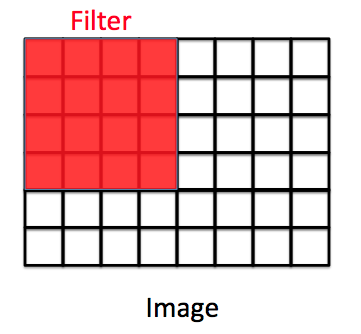

Stride = 2

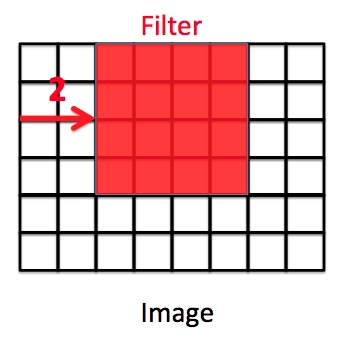

*   Padding : rajout de 0 sur les bords de notre entrée pour conserver la taille de notre image, ou pas justement.

    Filtre et perds de l'information -> bord de l'image pas forcément utile


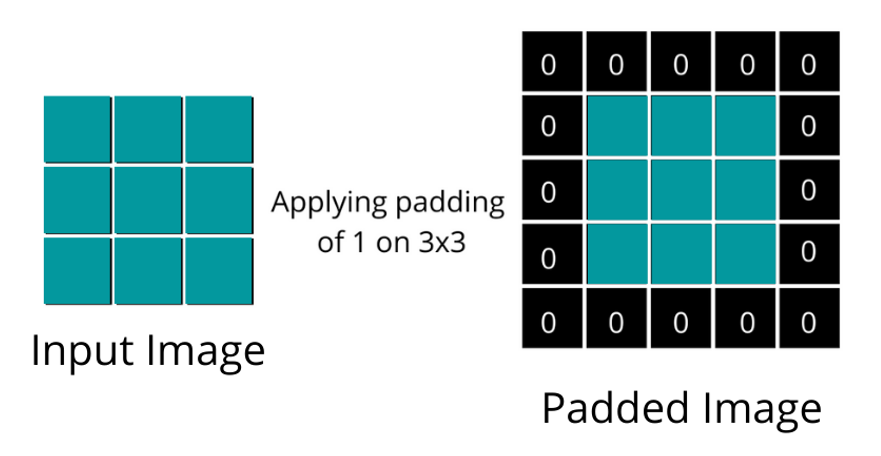

On distingue aussi la couche Flatten, qui va écraser comme son nom l'indique les features maps (en sortie de la dernière couche de convolution) en un objet de taille compatible avec la couche dense juste après (i.e un tenseur de dimension 1)

### **Hyperparamètres**

Les hyperparamètres sont les paramètres choisis par l'utilisateur, et qui ne sont pas appris au cours de l'entrainement par la machine. Ils vont typiquement correspondre au learning rate de la descente de gradient, à l'algorithme de descente de gradient, la taille de batch, la fonction de coût, ...

On définit nos ensembles de train et de test par une répartition aléatoire, 1800 images pour l'entraînement et 200 images pour le test.

On instancie des objets de classe **DataLoader** pour avoir une itération facile de notre dataset.
On prends une taille de batch (**batch_size**) de 20, signifiant qu'on insère 20 images à la fois pendant l'apprentissage.

In [ ]:
import math

batch_size = 20                                                                 # Taille de batch : combien d'images à la fois on met dans notre réseau

train_set, test_set = torch.utils.data.random_split(dataset, [1800,200])        # Il faut faire attention à ce que les train_size et test_size soient divisibles par la batch_size, sinon pytorch nous embête
train_loader = DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True) # "shuffle" indique que nos données sont bien mélangées, opération nécessaire car nos données étaient initialement rangées dans l'ordre
test_loader = DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

a = next(iter(train_loader))
a[0].size()

# Visualisation des dimensions d'un batch d'échantillons : [20, 3, 224, 224] car on a 20 images par batch,
# chaque image est RGB donc avec trois canaux, et de dimension 224 x 224 comme précisé précédemment

On a trois canaux à nos images, qui sont en RGB (red, blue, green), ce qui explique la dimension de nos tenseurs d'entrées :

(3 x 20 x 224 x 224), sachant que le batch_size = 20 et que nos images sont de taille 224x224.

In [ ]:
input_dim = dataset[0][0].shape[0]                                              # Nombre de channels dans l'image : 3
output_dim = len(classes)                                                       # Nombre de classes : 2 = dimension de la sortie

loss_nn = nn.CrossEntropyLoss()                                                 # Fonction de coût/perte : cross entropy loss

model = CNN(input_dim, output_dim)                                              # Initialisation du modèle en tant que classe CNN

learning_rate = 1e-3                                                            # Définition du learning rate, ou taux d'apprentissage, c'est un hyperparamètre
optimizer_nn = torch.optim.Adam(model.parameters(), lr=learning_rate)           # Fonction d'optimisation pour la descente de gradient

Petite manipulation pour observer les features maps après coup.

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Attacher des hooks aux couches de convolution
model.convs[0].register_forward_hook(get_activation('conv1'))
model.convs[2].register_forward_hook(get_activation('conv2'))
model.convs[4].register_forward_hook(get_activation('conv3'))

Résumé du réseau et du nombre de paramètres :

In [ ]:
summary(model,(3,224,224))                                                      # Affichage du réseau, avec le nombre de paramètres par couche entre autres


  **QCM**

In [ ]:
mcq(5)

Ces paramètres correspondent aux poids affinées lors de l'entraînement par descente et rétropropagation du gradient. Ce sont les termes de pondération et biais de nos couches denses, et les filtres et biais de nos couches convolutives.

## **Entraînement du réseau de neurones**

On lance l'entraînement et on récupère des données comme la précision et la perte en même temps :

In [ ]:
epochs = 5                                                                      # On itère 5 fois sur l'ensemble des données d'entraînement .
                                                                                # Une epoch = un passage sur l'ensemble du training dataset
iterations = 0
loss_list = []                                                                  # On initialise des liste pour récupérer après entraînement précision et perte du modèle en fonction des itérations
iteration_list = []
accuracy_list = []
accuracy = 0

for epoch in range(epochs):                                                     # Boucle d'entraînement sur 5 epochs
    for images, labels in train_loader:                                         # Itération à travers le chargeur de données d'entraînement "train_loader"

        model.train()

        train = images.view(batch_size, 3, 224, 224)                            # Réorganise les images pour correspondre au format attendu par le modèle, ici des images en 224x224 avec 3 canaux de couleurs.
        outputs = model(train)                                                  # On passe les images à travers le modèle pour obtenir les sorties prédites
        loss = loss_nn(outputs, labels)                                         # Calcul de la perte entre sorties prédites et étiquettes réelles

        predictions = torch.max(outputs, 1)[1]                                  # Calcul prédiction du modèle selon l'indice de la valeur max en sortie du vecteur

        optimizer_nn.zero_grad()                                                # Initialise les gradients du modèle à zéro avant d'effectuer la rétropropagation
        loss.backward()                                                         # Rétropropagation : calcul des gradients de perte par rapport aux paramètres du modèle
        optimizer_nn.step()                                                     # Optimisation : mise à jour des poids du modèle en fonction des gradients calculés

        iterations += 1                                                         # Incrémente l'itération sur un batch

        if iterations % 50 == 0:                                                # Lorsque le nombre d'itérations est un multiple de 100, on réalise une phase de test sur l'ensemble de données de test, avec mise à jour de la précision et de la perte
            corrects = 0
            total = 0

            for images, labels in test_loader:                                  # Itération à travers le chargeur de données de test "test_loader"

                test = images.view(batch_size, 3, 224, 224)
                model.eval()                                                    # On met le modèle en mode évaluation, pour réduire le nombre d'opérations effectuées sur les données
                with torch.no_grad():                                           # Aucun calcul ni stockage de gradients, accélère le calcul

                  outputs = model(test)
                  predict = torch.max(outputs.data, 1)[1]

                total += len(labels)
                corrects += (predict == labels).sum()

            model.train()

            accuracy = 100 * corrects / float(total)                            # Calcul de la précision

            loss_list.append(loss.data)
            iteration_list.append(iterations)
            accuracy_list.append(accuracy.data)

    print(f"Epoch: {epoch+1} | Loss: {loss.data} | Accuracy: {accuracy}")       # Affichage de la précision et de la perte(loss) au bout de chaque epoch

On a une précision très élevée, en comparaison avec notre réseau qui est relativement simple et notre dataset qui est lui très petit.

**QCM**

In [ ]:
mcq(2)

On déduit deux raisons quelques peu liées : le faible nombre d'exemples, et la pauvre diversité de notre dataset.

Un dataset adapté à les trois atouts suivants : des exemples de **qualité**, **divers**, et en grande **quantité**, ici ce sont la diversité et la quantité qui font défaut.

On jette un oeil à la précision et la loss calculées.

In [ ]:
import matplotlib.pyplot as plt

loss_L = [tensor.item() for tensor in loss_list]                                # On récupère les termes de perte
accuracy_L = [tensor.item() for tensor in accuracy_list]                        # On récupère les termes de précision

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
                                                                                # Premier sous-graphique: Loss vs Number of Iteration
axs[0].plot(iteration_list, loss_L)
axs[0].set_xlabel("Number of Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("CNN: Loss vs Number of Iteration")
axs[0].set_xlim([min(iteration_list),max(iteration_list)])
axs[0].set_ylim(0)

axs[1].plot(iteration_list, accuracy_L)                                         # Deuxième sous-graphique: Accuracy vs Number of Iteration
axs[1].set_xlabel("Number of Iteration")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("CNN: Accuracy vs Number of Iteration")
axs[1].set_xlim([min(iteration_list),max(iteration_list)])
axs[1].set_ylim([min(accuracy_L),max(accuracy_L)])

plt.tight_layout()
plt.show()


On atteint une perte quasi nulle et une précision parfaite au bout de la 5e epoch.

On observe les **filtres** de notre première couche (par pure curiosité) :

In [ ]:
conv1_weights_posttraining = model.convs[0].weight.data                         # Filtres de la 1e couche de convolution
conv2_weights_posttraining = model.convs[2].weight.data                         # Filtres de la 2e couche de convolution
conv3_weights_posttraining = model.convs[4].weight.data                         # Filtres de la 3e couche de convolution

# Nombre de filtres dans la première couche de convolution
num_filters = conv1_weights_posttraining.shape[0]

# Créer la figure pour afficher les filtres après l'entraînement
fig, axes = plt.subplots(1, num_filters, figsize=(12, 6))

for i, ax in enumerate(axes.flat):  # Afficher les filtres après l'entraînement
    filter_img = conv1_weights_posttraining[i].detach().cpu().numpy()
    if filter_img.ndim == 3:  # S'assurer que c'est une image RGB
        filter_img = filter_img.mean(axis=0)  # Prendre la moyenne sur les canaux
    ax.imshow(filter_img, cmap='gray')
    ax.set_title(f'Filtre {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# prédiction sur les images du data set

def prediction(index, data):
    img, _ = data[index]
    img = img.view([-1, 3, 224, 224])

    model.eval()

    with torch.no_grad():
      outputs = model(img)
      predict = torch.max(outputs.data, 1)[1]

    return classes[int(predict)]

index = 988                                             # Index à modifier, toujours entre 0 et 1999, pour prédire les différentes images de notre dataset

fig = plt.figure(figsize=(10, 7))

img, label = dataset[index]
predicted_label = prediction(index, dataset)

fig.add_subplot(1, 2, 1)
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title("Real Label: " + classes[int(label)])

fig.add_subplot(1,2,2)
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title("Predicted Label: " + predicted_label)

plt.show()

Notre réseau fonctionne très bien sur les images de notre dataset, mais ça ne veut pas dire pour autant que notre réseau a appris quelque chose.

Il peut tout simplement avoir appris par coeur les exemples de notre dataset, sans pour autant acquérir de schéma sur les données intrinsèques à nos espèces de poisson.


De ce fait, nous allons vérifier si notre réseau a appris quoi que ce soit en le testant sur des images d'internet prises au hasard, mais quand même parmi les classes sur lesquelles à appris le modèle : rouget ou brème de mer.


## **Test du réseau de neurones**

La fonction ci-dessous permet d'indiquer l'URL d'une image d'internet en entrée, pour avoir en sortie la prédiction du réseau dessus :

In [ ]:
# Petite fonction pour insérer un url d'image à insérer dans notre réseau pour une prédiction

def prediction(img_url):
    file_name = "image.jpg"
    !wget -O {file_name} {img_url} &> /dev/null
    img_path ="/content/" + str(file_name)
    img = Image.open(img_path)

    #Fonction de transformation qu'on applique à chaque image : changement de la taille en 224x224, conversion en tenseur
    transform2 = T.Compose([
        T.Resize((224,224)),                                                    # Taille mise en 224 x 224
        T.ToTensor()                                                            # Format tenseur
    ])

    img2 = transform2(img)

    img3 = img2.permute(1, 2, 0)                                                # Permutation des dimensions pour passer de (3, 224, 224) à (224, 224, 3)
    img3 = img3.numpy()                                                         # Convertir en tableau NumPy
    img3 = img3.clip(0, 1)                                                      # S'assurer que les valeurs sont comprises entre 0 et 1

    # image d'origine                                                           # On affichge l'image d'origine
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image d'origine")

    # image transformée                                                         # On affiche l'image transformée (i.e mise en tenseur et mise en taille 224 x 224)
    plt.subplot(1,2,2)
    plt.imshow(img3)
    plt.axis('off')  # Désactiver les axes
    plt.title('Image transformée')

    plt.show()

    img2 = img2
    img2 = img2.view([-1, 3, 224, 224])

    model.eval()
    with torch.no_grad():
      outputs = model(img2)
      predict = torch.max(outputs.data, 1)[1]

    !rm -r {img_path}

    print(f"Our network has predicted that this is a : " + classes[int(predict)])

**Prédiction sur des images d'internet**

 - **Rouget**

In [ ]:
Url_rouget = ["https://www.shutterstock.com/image-photo/red-mullet-isolated-260nw-33313192.jpg","https://img-3.journaldesfemmes.fr/iObfoi_h-MtiyrSVcJBBgWyGPbA=/1500x/smart/0f350bb4a16f445895cdfc0b861f74dc/ccmcms-jdf/11500214.jpg"]

for url in Url_rouget:
  prediction(url)

- **Brème de mer**

In [ ]:
Url_breme = ["https://upload.wikimedia.org/wikipedia/commons/b/b9/Pagrus_major_Red_seabream_ja01.jpg","https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR0ha93ZGw0PaIborknVUPkC1Z0Hys5-Zpn_w&usqp=CAU"]

for url in Url_breme:
  prediction(url)


Clairement, on voit que notre petit réseau n'est pas très bon lorsqu'il s'agit d'images différentes des exemples de la base de données.

On peut donc bien confirmer qu'il a fait du sur-apprentissage sur nos données.

Comment arranger ça ? Plusieurs solutions :

- Améliorer notre réseau de neurones
- Augmenter le nombre d'exemples d'apprentissage et les diversifier

Les deux solutions présentent des difficultés notamment en termes de ressources, il faut donc rester frugale dans notre approche.

## **Features maps**

Il peut être intéressant d'observer comment le réseau apprends à partir des images, notamment en regardant les "**features maps**".

Chaque couche convolutive applique des filtres, capables d'extraire des informations comme les contours, la texture, les paternes, des parties de l'image, ..., on appelle **features maps** la sortie de ces filtres.

Ces features maps correspondent donc aux informations extraites par nos couches convolutives.

Les résultats vont correspondre à la dernière entrée de notre réseau, ici ça sera l'image de brème de mer fournie juste au dessus.

In [ ]:
def plot_feature_maps(title,feature_maps, num_cols=6):

    feature_maps = feature_maps.cpu().numpy()
    N, C, H, W = feature_maps.shape
    num_rows = (C + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    for i, ax in enumerate(axes.flat):
        if i < C:
            ax.imshow(feature_maps[0, i, :, :], cmap='binary')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(title, fontsize=12)
    plt.show()

layers = ['conv1','conv2','conv3']
titles = ['1e couche conv','2e couche conv','3e couche conv']

for i in range (len(layers)) :
  plot_feature_maps(titles[i],activations[layers[i]],num_cols=8)

# Partie bonus : Data augmentation and enhancing the CNN

Nous allons essayer de rendre notre IA plus compétente.

Deux solutions s'offrent à nous :

- "augmenter" le jeu de données pour améliorer l'apprentissage, lui donner plus de données différentes à extraire. C'est un travail sur les données donc.

- optimiser notre réseau de neurones : rajouter des fonctionnalités qui rendent l'apprentissage plus "facile", rajouter des paramètres à notre réseau pour qu'il puisse capter des schémas plus "complexes".

Ces deux méthodes sont bien sûr complémentaires.


## **Data augmentation**

La première option est d'augmenter le jeu de données, faire ce qu'on appelle de la data augmentation. Cela consiste à générer de nouvelles données à partir de celles qu'on a déjà.

Pour ce faire, nous allons créer des copies de nos images sur lesquelles on va appliquer différents filtres, parmi les suivants :    
- Changer en nuances de gris
- Faire un changement de perspective
- Utiliser du flou Gaussien, normalement utilisé pour lisser et débruiter des images à l'aide d'une fonction gaussienne.
- Ajouter du bruit Gaussien. Rajoute du bruit sur l'image à l'aide d'une distribution Gaussienne
- Changer la luminosité, le contraste, le ton/teinte et la saturation d'une image

Cette approche apporte sans aucun doute de la diversité, mais reste limitée car on conserve la même base d'images de départ.

On définit une fonction d'augmentation de nos images :

In [ ]:
#Resize : changement de taille de l'image
resize_transform = T.Resize((224,224))

#Grayscale : mise en nuances de gris de l'image
grayscale_transform = T.Grayscale(3)

#Gausian Blur : flou gaussien
gausian_blur_transformation_56 = T.GaussianBlur(kernel_size = (7,13), sigma = (5 , 8))

#Elastic transformation
elastic_transformation = T.ElasticTransform(alpha = 200.0)

#Random perspective
perspective_transformation = T.RandomPerspective(p=1.0,distortion_scale=0.8)

#Random crop
size_of_crop = 100
random_crops = T.RandomCrop(size = size_of_crop)

#Gausian Noise : bruit gaussien
def addnoise(input_image, noise_factor = 0.3):
    inputs = T.ToTensor()(input_image)
    noisy = inputs + torch.rand_like(inputs) * noise_factor
    noisy = torch.clip (noisy,0,1.)
    output_image = T.ToPILImage()
    image = output_image(noisy)
    return image

#Colour Jitter : jeu sur les couleurs
colour_jitter_transformation_2 = T.ColorJitter(brightness=(0.7),contrast=(6),saturation=(0.9),hue=(-0.1,0.1))
colour_jitter_transformation_3 = T.ColorJitter(brightness=(0.5,1.5),contrast=(2),saturation=(1.4),hue=(-0.1,0.5))

#Random invert

random_invert_transform = T.RandomInvert()

def augment_image(img_path):

    #orig_image
    orig_img = Image.open(Path(img_path))

    #grayscale
    grayscaled_image=grayscale_transform(orig_img)

    #elastic
    elastic_img = elastic_transformation(orig_img)


    #random perspective
    pers_img = perspective_transformation(orig_img)

    # Random crop

    crop_image = resize_transform(random_crops(orig_img))

    #Gausian Blur
    gausian_blurred_image_56_image = gausian_blur_transformation_56(orig_img)

    #Gausian Noise
    gausian_image_9 = addnoise(orig_img,0.9)
    gausian_image_6 = addnoise(orig_img,0.6)

    #Inverted Image
    inver_image = random_invert_transform(orig_img)

    #Color Jitter
    colour_jitter_image_2 = colour_jitter_transformation_2(orig_img)
    colour_jitter_image_3 = colour_jitter_transformation_3(orig_img)

    return [grayscaled_image,elastic_img,pers_img,crop_image,gausian_blurred_image_56_image,gausian_image_6,gausian_image_9,colour_jitter_image_2,colour_jitter_image_3,inver_image]


def create_augmented_images(file_path_master_dataset):
    flag = 0  # Compteur pour quelques images du dataset seulement, afin de limiter le temps de calcul

    for root, dirs, files in os.walk(file_path_master_dataset):
        for file_name in files:
            file_path = os.path.join(root, file_name)

            # Vérifier si le fichier est une image
            try:
                image = Image.open(file_path)
            except Exception as e:
                print(f"Erreur lors de l'ouverture de l'image {file_path}: {e}")
                continue

            # Vérification flag
            if flag == 4:
                flag = 0
                # Génération
                required_images = augment_image(file_path)

                # Sauvegarde
                counter = 0
                for augmented_image in required_images:
                    augmented_image.save(os.path.join(root, f"{counter}_{file_name}"))
                    counter += 1

            flag += 1

On regarde l'effet des transformations sur la première image de notre dataset, une image de Rouget.

In [ ]:
L = augment_image("/content/Formation-Introduction-Deep-Learning/Fish Dataset/Red Mullet/00001.png")

num_images = len(L)
num_cols = 4
num_rows = -(-num_images // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(L[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Désactiver les axes pour les cases vides

plt.tight_layout()
plt.show()

L'idée est d'appliquer la fonction à notre dataset pour l'augmenter et générer de nouvelles images, dans le bus de poser plus de difficultés à notre réseau lors de l'apprentissage sur ces données. On l'applique sur un quart des images seulement pour observer les effets et gagner du temps.

In [ ]:
data_dir = """/content/Formation-Introduction-Deep-Learning/Fish Dataset"""
classes = ["Red Mullet","Red Sea Bream"]

create_augmented_images(f"{data_dir}/{classes[0]}")
create_augmented_images(f"{data_dir}/{classes[1]}")

En pratique, j'ai réalisé les transformations de mon côté sur la moitié des images pour effectuer un entraînement "optimal". On ne fait pas ça aujourd'hui par un souci évident de temps.

On parcourt les mêmes étapes que précemment.

## **Préparation Data set**

In [ ]:
_, _, files = next(os.walk(f"{data_dir}/{classes[0]}"))
file_count = len(files)

**QCM time :**

In [ ]:
mcq(3)

In [ ]:
# Utiliser cette ligne de code pour trouver la réponse


De la même manière que j'ai préparé un jeu de données plus large de mon côté, j'ai réalisé toutes les étapes de la préparation des données à l'entraînement du réseau.

In [ ]:
#Ne pas lancer##################################################################
################################################################################

image_paths2 = []
image_classes = np.array([[cls]*file_count for cls in classes]).reshape(-1)     # On crée un tableau

for cls in classes:
                                                                                # On ajoute dans la première colonne le chemin d'accès à chaque image
    image_paths2.extend(os.path.join(data_dir, cls, i) for i in os.listdir(os.path.join(data_dir, cls)))

data2 = pd.DataFrame({'path':image_paths2, 'class':image_classes, })            # On crée le DataFrame Pandas

print(data2)

In [ ]:
#Ne pas lancer##################################################################
################################################################################

#Fonction de transformation qu'on applique à chaque image

transform2 = T.Compose([
        T.ToTensor()])

#On crée le DataSet Torch à partir de notre Dataset Pandas

str_to_int = {
 'Red Mullet': 0,
 'Red Sea Bream': 1
}

class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=T.ToTensor()):                 # Le constructeur de classe prends trois paramètres
        self.data = data                                                        # dataFrame contenant les données
        self.root_dir = root_dir                                                # répertoire racine où se trouvent les données
        self.transform = transform                                              # une transformation à appliquer sur les images

    def __len__(self):                                                          # méthode qui renvoie la longueur de l'ensemble de données, i.e le nombre d'échantillons dans le dataset
        return len(self.data)

    def __getitem__(self, idx):                                                 # méthode pour indexer les données : prends un index en entrée et renvoie l'échantillon sous forme de tuple
        if torch.is_tensor(idx):                                                # utilisation d'un index donné
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]                                       # récupération fichier image
        image = Image.open(img_name)                                            # chargement de l'image à partir du fichier
        y_label = torch.tensor(str_to_int[self.data.iloc[idx, 1]])              # récupération du label/étiquette de l'image, et conversion en entier avec le dictionnaire str_to_int
        if self.transform:                                                      # application de la transformation si spécifié
            image = self.transform(image)
        return (image, y_label)

dataset2 = MarketFishDataset(                                                   # création d'une instance de MarketFishDataset nommée "dataset2"
    data=data2,
    root_dir=data_dir,
    transform=transform2)

## **Définition réseau de neurones**

La deuxième approche pour améliorer notre IA est d'augmenter les capacités de notre réseau de neurones.

On crée donc une nouvelle classe de CNN, différente de notre réseau précédent. On rajoute notamment des couches de régularisation et de normalisation.

La régularisation (Dropout) met aléatoirement à zéro des neurones de manière temporaire, ce qui permet d'améliorer l'apprentissage en déstabilisant le réseau.

La normalisation va comme son nom l'indique normaliser les valeurs entre 0 et 1. Ce procédé est reconnu pour stabiliser et rendre plus efficace l'apprentissage.

On trouve de plus des filtres plus petit, et des paramètres de stride moins conséquent, ce qui implique deux choses :

- Moins d'informations est perdu
- Beaucoup plus de paramètres à entraîner

In [ ]:
class CNN_2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(CNN_2, self).__init__()
        self.out_dim = out_dim

        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.f1 = nn.Flatten()
        self.q1 = nn.Linear(200704, 128)
        self.b1 = nn.BatchNorm1d(128)
        self.r1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.q2 = nn.Linear(128, out_dim)

    def forward(self, x):
        conv = self.convs(x)
        f1 = self.f1(conv)
        q1= self.q1(f1)
        b1 = self.b1(q1)
        r1 = self.r1(b1)
        d1 = self.d1(r1)
        q = self.q2(d1)
        return q

input_dim = 3                                             # Nombre de channels dans l'image : 3
output_dim = len(classes)                                                       # Nombre de classes : 2

model2 = CNN_2(in_dim=input_dim, out_dim=output_dim)

loss_nn = nn.CrossEntropyLoss()                                                 # Fonction de perte : cross entropy
learning_rate = 1e-4                                                            # Learning rate / taux d'apprentissage
optimizer_nn = torch.optim.Adam(model2.parameters(), lr=learning_rate)          # Fonction d'optimisation

# On réalise la même manipulation pour observer notre features maps après coup

activations = {}

def get_activation(name):
    def hook(model2, input, output):
        activations[name] = output.detach()
    return hook

# Attacher des hooks aux couches de convolution
model2.convs[0].register_forward_hook(get_activation('conv1'))
model2.convs[3].register_forward_hook(get_activation('conv2'))
model2.convs[6].register_forward_hook(get_activation('conv3'))

On regarde notre nouveau modèle et son nombre de paramètres

In [ ]:
summary(model2,(3,224,224))                                                      # Affichage du réseau, avec le nombre de paramètres par couche entre autres

On a 25 fois plus de paramètres que sur notre premier modèle : ~ 25 millions.

Quelle(s) implication(s) pour notre exercice?

**QCM**

In [ ]:
mcq(4)

On ne lance pas d'entraînement de notre réseau, car ça serait beaucoup trop long.

En revanche on récupère les poids du réseau déjà entraîné au préalable de mon côté, de la manière suivante :

In [ ]:
path = '/content/Formation-Introduction-Deep-Learning/Fish Dataset/big_model_trained.pth'     # Chemin vers les poids du modèle entraîné de mon côté

model_dict = torch.load(path)                                                   # On charge les poids dans un dictionnaire

model2.load_state_dict(model_dict)                                              # On charge les poids dans notre modèle

On récupère de la même façon les données récupérées pendant l'entraînement : l'erreur, la précision, et les itérations.

In [ ]:
chemin_metrics = '/content/Formation-Introduction-Deep-Learning/Fish Dataset/metrics.pth' # Chemin où se trouvent les métriques sauvegardées

metrics_dict = torch.load(chemin_metrics)                                       # Chargez les métriques dans un dictionnaire

loss_list = metrics_dict['loss']                                                # Récupération termes de perte
accuracy_list = metrics_dict['accuracy']                                        # Récupération termes de précision
iteration_L = metrics_dict['iteration']                                         # Récupération termes d'itérations


On les affiche graphiquement :

In [ ]:
import matplotlib.pyplot as plt

loss_L = [tensor.item() for tensor in loss_list]                                # On récupère les termes de perte
accuracy_L = [tensor.item() for tensor in accuracy_list]                        # On récupère les termes de précision

# Créer une figure contenant deux sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(iteration_L, loss_L)                                                # Premier sous-graphique: Loss vs Number of Iteration
axs[0].set_xlabel("Number of Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("CNN: Loss vs Number of Iteration")
axs[0].set_xlim([min(iteration_L),max(iteration_L)])
axs[0].set_ylim(0)

axs[1].plot(iteration_L, accuracy_L)                                            # Deuxième sous-graphique: Accuracy vs Number of Iteration
axs[1].set_xlabel("Number of Iteration")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("CNN: Accuracy vs Number of Iteration")
axs[1].set_xlim([min(iteration_L),max(iteration_L)])

plt.tight_layout()
plt.show()


La précision est déjà beaucoup plus cohérente.

Raisons :


*   Dataset plus grand : plus d'images à traiter
*   Plus de poids à évaluer lors de la descente de gradient et la rétropropagation




On regarde l'évolution des termes de précision et loss.

Comme avant, on essaie de voir si notre réseau a réellement appris, en réalisant des inférences sur des images d'internet.

In [ ]:
# Fonction de prédiction à partir d'une url d'internet

def prediction2(img_url):
    file_name = "image.jpg"
    !wget -O {file_name} {img_url} > /dev/null 2>&1
    img_path ="/content/" + str(file_name)
    img = Image.open(img_path)

    #Fonction de transformation qu'on applique à chaque image : changement de la taille en 224x224, conversion en tenseur, normalisation des pixels

    transform2 = T.Compose([
        T.Resize((224,224)),                                                    # Taille mise en 224 x 224
        T.ToTensor()                                                            # Format tenseur
    ])

    img2 = transform2(img)
    img3 = img2.permute(1, 2, 0)                                                # Permutation des dimensions pour passer de (3, 224, 224) à (224, 224, 3)
    img3 = img3.numpy()                                                         # Convertir en tableau NumPy
    img3 = img3.clip(0, 1)                                                      # S'assurer que les valeurs sont comprises entre 0 et 1

    # image d'origine                                                           # On affichge l'image d'origine
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image d'origine")

    # image transformée                                                         # On affiche l'image transformée (i.e mise en tenseur et mise en taille 224 x 224)
    plt.subplot(1,2,2)
    plt.imshow(img3)
    plt.axis('off')  # Désactiver les axes
    plt.title('Image transformée')

    plt.show()

    img2 = img2
    img2 = img2.view([-1, 3, 224, 224])

    model2.eval()
    with torch.no_grad():
      outputs = model2(img2)
      print(outputs)
      predict = torch.max(outputs.data, 1)[1]

    !rm -r {img_path}

    print(f"Our network has predicted that this is a : " + classes[int(predict)])


**Images de rouget** :

In [ ]:
Url_rouget = ["https://www.shutterstock.com/image-photo/red-mullet-isolated-260nw-33313192.jpg",
              "https://img-3.journaldesfemmes.fr/iObfoi_h-MtiyrSVcJBBgWyGPbA=/1500x/smart/0f350bb4a16f445895cdfc0b861f74dc/ccmcms-jdf/11500214.jpg"]

for url in Url_rouget:
  prediction2(url)


**Images de brème de mer** :

In [ ]:
Url_breme = ["https://upload.wikimedia.org/wikipedia/commons/b/b9/Pagrus_major_Red_seabream_ja01.jpg",
             "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR0ha93ZGw0PaIborknVUPkC1Z0Hys5-Zpn_w&usqp=CAU",
             "https://www.crushpixel.com/big-static11/preview4/raw-sea-bream-694330.jpg"]

for url in Url_breme:
  prediction2(url)

Bon ...

Malgré l'augmentation des données et l'utilisation d'un modèle bien plus conséquent, le réseau n'arrive pas à extrapoler sur des images externes à sa base d'entraînement.

Cela souligne d'autant plus l'importance du choix des données, qui peut dans notre cas décider totalement des capacités de notre réseau de neurones.


## **Features maps**

On regarde les features map de ce réseau, qui conserve plus d'information et donc devrait renvoyer des features maps plus précises.

In [ ]:
def plot_feature_maps(title,feature_maps, num_cols=6):

    feature_maps = feature_maps.cpu().numpy()
    N, C, H, W = feature_maps.shape
    num_rows = (C + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    for i, ax in enumerate(axes.flat):
        if i < C:
            ax.imshow(feature_maps[0, i, :, :], cmap='binary')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(title, fontsize=12)
    plt.show()


layers = ['conv1','conv2','conv3']
titles = ['1e couche conv','2e couche conv','3e couche conv']

for i in range (len(layers)) :
  plot_feature_maps(titles[i],activations[layers[i]],num_cols=8)

# **Les poissons c'est bien, avoir un réseau qui marche c'est mieux**



C'est bien beau d'apprendre à un réseau mais si ça ne marche pas, à quoi ça sert ?

Malgré notre échec sur la classification de poissons, classifier par des réseaux de neurones est bien une tâche réalisable lorsque l'on a des données de qualité.

Preuve ci-contre, sur des images de **chiens** et **chats**.

Le réseau qu'on utilise :

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()


        self.cnn = nn.Sequential(                                               # dimensions entrée                 : [1, 128, 128]
            nn.Conv2d(1, 64, 3, 1, 1),                                          # dimensions sortie de cette couche : [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),                                              # dimensions sortie de cette couche : [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1),                                        # dimensions sortie de cette couche : [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),                                              # dimensions sortie de cette couche : [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1),                                       # dimensions sortie de cette couche : [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),                                              # dimensions sortie de cette couche : [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1),                                       # dimensions sortie de cette couche : [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),                                              # dimensions sortie de cette couche : [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1),                                       # dimensions sortie de cette couche : [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),                                              # dimensions sortie de cette couche : [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

model = Classifier()

In [ ]:
summary(model,(1,128,128))

On a là un réseau à mi-chemin entre les deux modèles crées au dessus, avec 12 millions de paramètres.

L'apprentissage a été réalisé de mon côté sur ~ 25000 images, 12500 de chats et 12500 de chiens.

Les images ont été prise en dimension 128x128, avec un seul canal et non pas trois comme les images RGB exploités avant.

In [ ]:
loaded_data = torch.load('/content/Formation-Introduction-Deep-Learning/Fish Dataset/saved_model_catdog.pth')

loaded_model_weights = loaded_data['model_weights']

classes = ["Cat","Dog"]


In [ ]:
model.load_state_dict(loaded_model_weights)                                     # On charge les poids dans notre modèle

On observe les données d'apprentissage :

In [ ]:
from PIL import Image

image_path = "/content/Formation-Introduction-Deep-Learning/Fish Dataset/output.png"
img = Image.open(image_path)

img


In [ ]:
# Petite fonction pour insérer un url d'image à insérer dans notre réseau pour une prédiction

def prediction(img_url):
    file_name = "image.jpg"
    !wget -O {file_name} {img_url} &> /dev/null
    img_path ="/content/" + str(file_name)
    img = Image.open(img_path)

    #Fonction de transformation qu'on applique à chaque image : changement de la taille en 224x224, conversion en tenseur
    transform2 = T.Compose([
        T.Resize((128,128)),                                                    # Taille mise en 224 x 224
        T.Grayscale(num_output_channels=1),
        T.ToTensor()                                                            # Format tenseur
    ])

    img2 = transform2(img)

    img3 = img2.permute(1, 2, 0)                                                # Permutation des dimensions pour passer de (3, 224, 224) à (224, 224, 3)
    img3 = img3.numpy()                                                         # Convertir en tableau NumPy
    img3 = img3.clip(0, 1)                                                      # S'assurer que les valeurs sont comprises entre 0 et 1

    # image d'origine                                                           # On affichge l'image d'origine
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image d'origine")

    # image transformée                                                         # On affiche l'image transformée (i.e mise en tenseur et mise en taille 224 x 224)
    plt.subplot(1,2,2)
    plt.imshow(img3)
    plt.axis('off')  # Désactiver les axes
    plt.title('Image transformée')

    plt.show()

    img2 = img2
    img2 = img2.view([-1, 1, 128, 128])

    model.eval()
    with torch.no_grad():
      outputs = model(img2)
      predict = torch.max(outputs.data, 1)[1]

    !rm -r {img_path}

    print(f"Our network has predicted that this is a : " + classes[int(predict)])


In [ ]:
Urls = ["https://thumbs.dreamstime.com/b/crabot-de-chien-d-arr%C3%AAt-d-21668976.jpg",
        "https://cdn.pixabay.com/photo/2021/07/13/11/34/cat-6463284_640.jpg",
        "https://img.freepik.com/photos-gratuite/adorable-chien-basenji-brun-blanc-souriant-donnant-haut-cinq-isole-blanc_346278-1657.jpg",
        "https://www.shutterstock.com/image-photo/charming-kitten-on-gray-background-600nw-2322539671.jpg"

        ]

for url in Urls:
  prediction(url)

On s'aperçoit là qu'avec un bon réseau et surtout un jeu de données de qualité, notre modèle est désormais capable de s'appliquer à des images extérieures au dataset d'entraînement.

# **Questionnaire de satisfaction**

~ 3-5 minutes

Merci de le remplir si vous avez le temps, avoir des retours nous est crucial.

https://sondage.umontpellier.fr/ls/index.php/918278?lang=fr
